In [73]:
#imports
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from SPARQLWrapper import SPARQLWrapper, JSON

import json


sns.set_style("whitegrid")
pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.

# 1) DATA LOADING


In [74]:
#read tsv file and add headers
movie_metadata_df = pd.read_csv('data/movie.metadata.tsv', sep='\t', header=None, 
                names=['wiki_movie_id', 
                        'freebase_movie_id', 
                        'movie_name', 
                        'movie_release_date', 
                        'movie_box_office_revenue', 
                        'movie_runtime', 
                        'movie_languages', 
                        'movie_countries', 
                        'movie_genres'])

#changing the values of outliers
movie_metadata_df.loc[movie_metadata_df['movie_name'] == 'Zero Tolerance', 'movie_runtime'] = 88
movie_metadata_df.loc[movie_metadata_df['movie_name'] == 'Hunting Season', 'movie_release_date'] = '2010-12-02'

#add realase_year 
movie_metadata_df['startYear']= movie_metadata_df['movie_release_date'].str[:4]

#change movie_release_date to pandas datetime
movie_metadata_df['movie_release_date'] = pd.to_datetime(movie_metadata_df['movie_release_date'], format='%Y-%m-%d', errors='coerce')
movie_metadata_df.head(10)


,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,startYear
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000
2,28463795,/m/0crgdbh,Brun bitter,1988-01-01,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988
3,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1987
4,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983
5,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913
6,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002-01-01,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...",2002
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938
8,9997961,/m/06_y2j7,Contigo y aquí,1974-01-01,NaN,NaN,"{""/m/06nm1"": ""Spanish Language""}","{""/m/0jgd"": ""Argentina""}","{""/m/04t36"": ""Musical"", ""/m/07s9rl0"": ""Drama"",...",1974
9,2345652,/m/075f66,City of the Dead,1960-01-01,NaN,76.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/03npn"": ""Horror"", ""/m/0fdjb"": ""Supernatur...",1960


In [75]:
#load IMDB reviews
rating_id_df = pd.read_csv('data/rating_id.tsv',  sep='\t')
name_id_df = pd.read_csv('data/name_id.tsv',  sep='\t')
rating_df = pd.merge(rating_id_df, name_id_df, on='tconst')

#drop unnecessary columns 
rating_df.drop(['originalTitle','isAdult','endYear','runtimeMinutes','genres'], axis=1, inplace=True)
rating_df.sample(10)

<ipython-input-75-322c79a2c8c9>:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  name_id_df = pd.read_csv('data/name_id.tsv',  sep='\t')


,tconst,averageRating,numVotes,titleType,movie_name,startYear
291870,tt0558757,6.0,5,tvEpisode,Red Brady's Kid,1964
1350892,tt9358156,7.8,20,tvEpisode,Stars of the Silver Scream,2018
668464,tt1415923,8.7,207,tvEpisode,Both the Life of an Immortal and a Mortal Are ...,2007
602207,tt12830908,7.3,168,movie,De Dick Maas Methode,2020
1367804,tt9896208,9.2,22,tvEpisode,Raksha-Bandhan Special: How Brothers irritate ...,2017
1355382,tt9500030,9.0,8,video,The Beast,2018
55601,tt0079402,5.8,37,movie,The Killing Ground,1979
762337,tt16439266,6.3,15,tvEpisode,Sound of Dream,2021
1096233,tt4404986,5.8,12,tvEpisode,Will the Real Gigantor Stand Up?,1964
628852,tt13350858,4.6,554,movie,Battle: Freestyle,2022


In [76]:
#loading the events dataset 
events = pd.read_csv('data/events.csv')
events.head()

,Year,Event Name,Event Description,Event Location,Event Category
0,1820,Missouri Compromise,The Missouri Compromise was a major political ...,United States,Political Events
1,1820,Discovery of Antarctica,"In the year 1820, an extremely significant eve...",Antarctica,Scientific Discoveries and Advancements
2,1820,Cato Street Conspiracy,This event was an attempt to murder all the Br...,United Kingdom,Political Events
3,1820,Comanche Campaign,The Comanche Campaign was a series of military...,United States,Military Conflicts
4,1820,Tom Thumb Engine,The Tom Thumb was the first American-built ste...,United States,Economic Events


In [77]:
#loading the plot summaries dataset and add headers
plot_summaries_df = pd.read_csv('data/plot_summaries.txt', sep='\t', header=None, 
                names=['wiki_movie_id', 
                        'plot_summary'])
plot_summaries_df.head(10)

,wiki_movie_id,plot_summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...
5,5272176,The president is on his way to give a speech. ...
6,1952976,"{{plot}} The film opens in 1974, as a young gi..."
7,24225279,"The story begins with Hannah, a young Jewish t..."
8,2462689,Infuriated at being told to write one final co...
9,20532852,A line of people drool at the window of the s...


In [78]:
#read text file and add headers, name.clusters.txt
name_clusters_df = pd.read_csv('data/name.clusters.txt', sep='\t', header=None, 
                names=['character_name', 
                        'freebase_character_actor_map_id'])
name_clusters_df.head(10)

,character_name,freebase_character_actor_map_id
0,Stuart Little,/m/0k3w9c
1,Stuart Little,/m/0k3wcx
2,Stuart Little,/m/0k3wbn
3,John Doe,/m/0jyg35
4,John Doe,/m/0k2_zn
5,Josh Framm,/m/0jt3p3
6,Josh Framm,/m/0jt3t3
7,Caspian X,/m/0646flc
8,Caspian X,/m/02vd12n
9,Apostle Peter,/m/02vd6_v


In [79]:
#read text file and add headers
character_metadata_df = pd.read_csv('data/character.metadata.tsv', sep='\t', header=None, 
                names=['wiki_movie_id',
                        'freebase_movie_id',
                        'movie_release_date',
                        'character_name',
                        'actor_date_of_birth',
                        'actor_gender',
                        'actor_height',
                        'actor_ethnicity',
                        'actor_name',
                        'actor_age_at_movie_release',
                        'freebase_character_actor_map_id',
                        'freebase_character_id',
                        'freebase_actor_id'])
character_metadata_df.head(10)

,wiki_movie_id,freebase_movie_id,movie_release_date,character_name,actor_date_of_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
5,975900,/m/03vyhn,2001-08-24,Commander Helena Braddock,1949-05-26,F,1.727,/m/0x67,Pam Grier,52.0,/m/02vdcfp,/m/0bgchnd,/m/0418ft
6,975900,/m/03vyhn,2001-08-24,Whitlock,1945-08-02,F,1.753,NaN,Joanna Cassidy,56.0,/m/02vd6kw,/m/0bgchmx,/m/06lj1m
7,975900,/m/03vyhn,2001-08-24,Big Daddy Mars,NaN,M,NaN,NaN,Richard Cetrone,NaN,/m/0bgchsy,/m/0bgcht0,/m/0bgcht7
8,975900,/m/03vyhn,2001-08-24,Michael Descanso,1971-03-20,M,1.892,NaN,Liam Waite,30.0,/m/03jqhb0,/m/0bgchs4,/m/0ks8b0
9,975900,/m/03vyhn,2001-08-24,Uno,NaN,M,NaN,NaN,Duane Davis,NaN,/m/0bgchtj,/m/0bgchtm,/m/03nrwdy


In [80]:
#read text file and add headers
tvtropes_clusters_df = pd.read_csv('data/tvtropes.clusters.txt', sep='\t', header=None, names=['character_type', 'data_dict'])
#transform second column to columns
tvtropes_clusters_df['data_dict'] = tvtropes_clusters_df['data_dict'].apply(json.loads)
tvtropes_clusters_df = pd.concat([tvtropes_clusters_df.drop(['data_dict'], axis=1), tvtropes_clusters_df['data_dict'].apply(pd.Series)], axis=1)
#rename columns
tvtropes_clusters_df.columns = ['character_type', 'character_name', 'movie_name', 'freebase_character_actor_map_id', 'actor_name']
tvtropes_clusters_df.head(10)

,character_type,character_name,movie_name,freebase_character_actor_map_id,actor_name
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader
5,adventurer_archaeologist,Indiana Jones,Indiana Jones and the Kingdom of the Crystal S...,/m/0jzx78,Harrison Ford
6,adventurer_archaeologist,Indiana Jones,Indiana Jones and the Raiders of the Lost Ark,/m/0k294p,Harrison Ford
7,adventurer_archaeologist,Indiana Jones,Indiana Jones and the Temple of Doom,/m/0jzx9b,Harrison Ford
8,adventurer_archaeologist,Evelyn Carnahan-O'Connell,The Mummy,/m/0k5yzc,Rachel Weisz
9,arrogant_kungfu_guy,Han,Enter the Dragon,/m/02vd8hn,Shih Kien


In [81]:
tvtropes_clusters_df.sample(10)

,character_type,character_name,movie_name,freebase_character_actor_map_id,actor_name
144,crazy_jealous_guy,Bud White,L.A. Confidential,/m/0j_n0t,Russell Crowe
5,adventurer_archaeologist,Indiana Jones,Indiana Jones and the Kingdom of the Crystal S...,/m/0jzx78,Harrison Ford
493,warrior_poet,T. E. Lawrence,Lawrence of Arabia,/m/0j_tdt,Peter O'Toole
124,corrupt_corporate_executive,Ian Hawke,Alvin and the Chipmunks,/m/03kyztz,David Cross
105,consummate_professional,The Professor,The Bourne Identity,/m/0k4kdl,Clive Owen
99,charmer,Hannibal Lecter,The Silence of the Lambs,/m/0k6g86,Anthony Hopkins
128,corrupt_corporate_executive,Dietrich Banning,The Tuxedo,/m/0cgn58l,Ritchie Coster
367,ophelia,Crazy Cora,Quigley Down Under,/m/02tb5g1,Laura San Giacomo
279,granola_person,Lotte Schwartz,Being John Malkovich,/m/0jv6mp,Cameron Diaz
254,father_to_his_men,Zordon,Mighty Morphin' Power Rangers: The Movie,/m/0k0nmw,Nicholas Bell


# 2) MERGING OUR DATA WITH THE IMDB RATINGS DATASET

In [82]:
#merging the movie metadata with the rating data on movie name and release year
movies_ratings = pd.merge(movie_metadata_df, rating_df,  on=['movie_name', 'startYear'])
movies_ratings.shape


(51107, 14)

# 3) CLEANING THE DATA

In [83]:
# printing the types of the merged data 
movies_ratings['titleType'].unique()

array(['movie', 'tvEpisode', 'short', 'tvMovie', 'video', 'tvSeries',
       'videoGame', 'tvMiniSeries', 'tvSpecial', 'tvShort'], dtype=object)

In [84]:
#remove any {{ }} from the plot summary text
plot_summaries_df['plot_summary'] = plot_summaries_df['plot_summary'].str.replace(r'\{\{.*?\}\}', '', regex=True)

In [85]:
# keeping only movies, delete tv episodes, tv movies, video games, etc.
movies_ratings = movies_ratings[movies_ratings['titleType']=='movie']
movies_ratings.sample(20)

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,startYear,tconst,averageRating,numVotes,titleType
16830,20427601,/m/04zz1gd,The Reckless,1965-02-18,NaN,100.0,"{""/m/02bjrlw"": ""Italian Language""}","{""/m/03rjj"": ""Italy""}","{""/m/07s9rl0"": ""Drama""}",1965,tt0157372,7.0,45,movie
50753,1158236,/m/04c4fd,King of the Hill,1993-08-20,1.214231e+06,109.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",1993,tt0107322,7.3,8689,movie
41596,19609617,/m/04myqym,Rajput,1982-04-16,NaN,120.0,"{""/m/03k50"": ""Hindi Language""}","{""/m/03rk0"": ""India""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/02l7c8"": ""Ro...",1982,tt0155088,6.5,193,movie
47709,25876137,/m/09v94sd,Artistka,2007-01-01,NaN,100.0,{},"{""/m/06bnz"": ""Russia""}","{""/m/02l7c8"": ""Romance Film""}",2007,tt1116026,6.8,303,movie
23127,2167778,/m/06rwz6,Loggerheads,2005-01-01,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hn10"": ""LGBT"", ""/m/02h8pkk"": ""Family Dra...",2005,tt0406038,7.2,1842,movie
50351,34236417,/m/0hzs4n9,Miss Priyambada,1967-08-18,NaN,NaN,"{""/m/01c7y"": ""Bengali Language""}",{},"{""/m/02l7c8"": ""Romance Film"", ""/m/05p553"": ""Co...",1967,tt5625458,7.0,16,movie
6732,32884821,/m/0hzp8lf,Bodyguard,2012-01-14,NaN,NaN,{},{},"{""/m/05p553"": ""Comedy film"", ""/m/02kdv5l"": ""Ac...",2012,tt2100411,5.1,460,movie
43422,17062305,/m/04173p1,On the Job Training,2007-10-27,NaN,85.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama"", ""/m/0219x_"": ""Indie"", ...",2007,tt1107838,7.5,23,movie
9899,28302378,/m/0cnyvtg,Crashing Las Vegas,1956-04-22,NaN,62.0,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/05p553"": ""Comedy film"", ""/m/02kdv5l"": ""Ac...",1956,tt0049101,5.7,360,movie
6295,20109381,/m/0crtrnm,Voices,2007-01-01,1.760707e+06,84.0,"{""/m/02hwhyv"": ""Korean Language""}","{""/m/06qd3"": ""South Korea""}","{""/m/03npn"": ""Horror"", ""/m/01585b"": ""Slasher"",...",2007,tt1213856,5.5,1367,movie


In [86]:
# only keep the movies with more than 100 votes on imdb ratings
movies_ratings = movies_ratings[movies_ratings['numVotes']>200]
movies_ratings.shape

(27739, 14)

In [87]:
#keep movie_metadata_df only with movies that have ratings
movie_metadata_df = movie_metadata_df[movie_metadata_df['freebase_movie_id'].isin(movies_ratings['freebase_movie_id'])]
movie_metadata_df.shape

(27655, 10)

In [88]:
#keep the summaries of the selected movies 
plot_summaries_df = plot_summaries_df[plot_summaries_df['wiki_movie_id'].isin(movie_metadata_df['wiki_movie_id'])]
plot_summaries_df.shape

(20161, 2)

In [89]:
#keep movie_metadata_df only with movies that have summaries
movie_metadata_df = movie_metadata_df[movie_metadata_df['wiki_movie_id'].isin(plot_summaries_df['wiki_movie_id'])]
movie_metadata_df.shape

(20161, 10)

In [90]:
#keep the character_metadata_df only with movies that have summaries and ratings
character_metadata_df = character_metadata_df[character_metadata_df['wiki_movie_id'].isin(movie_metadata_df['wiki_movie_id'])]

In [91]:
#keep the tvtropes_clusters_df only with movies that have summaries and ratings
tvtropes_clusters_df = tvtropes_clusters_df[tvtropes_clusters_df['freebase_character_actor_map_id'].isin(character_metadata_df['freebase_character_actor_map_id'])]

# 2) DATA INSIGHTS

In [92]:
#create a dataframe with only the movie languages
movie_languages_df = movie_metadata_df[['freebase_movie_id', 'movie_languages']]
movie_languages_df['movie_languages'] = movie_metadata_df['movie_languages'].apply(json.loads)
print(movie_languages_df.head(10))
movie_languages_df = movie_languages_df.explode('movie_languages')
movie_languages_df.rename(columns={'movie_languages':'freebase_languages_id'}, inplace=True)
movie_languages_df.head(10)

   freebase_movie_id                                    movie_languages
0          /m/03vyhn                 {'/m/02h40lc': 'English Language'}
4          /m/01mrr1                  {'/m/04306rv': 'German Language'}
13         /m/016ywb                 {'/m/02h40lc': 'English Language'}
17          /m/0kcn7                 {'/m/02h40lc': 'English Language'}
22        /m/05p45cv                                                 {}
29         /m/014k4y                 {'/m/02h40lc': 'English Language'}
31        /m/02pml15                 {'/m/0999q': 'Malayalam Language'}
38        /m/0b6c_nw                                                 {}
47        /m/0b6kc_5                 {'/m/02h40lc': 'English Language'}
49         /m/01mrrd  {'/m/0x82': 'Afrikaans Language', '/m/02h40lc'...


,freebase_movie_id,freebase_languages_id
0,/m/03vyhn,/m/02h40lc
4,/m/01mrr1,/m/04306rv
13,/m/016ywb,/m/02h40lc
17,/m/0kcn7,/m/02h40lc
22,/m/05p45cv,NaN
29,/m/014k4y,/m/02h40lc
31,/m/02pml15,/m/0999q
38,/m/0b6c_nw,NaN
47,/m/0b6kc_5,/m/02h40lc
49,/m/01mrrd,/m/0x82


In [93]:
#create a dataframe with only the movie countries
movie_countries_df = movie_metadata_df[['freebase_movie_id', 'movie_countries']]
movie_countries_df['movie_countries'] = movie_metadata_df['movie_countries'].apply(json.loads)
movie_countries_df = movie_countries_df.explode('movie_countries')
movie_countries_df.rename(columns={'movie_countries':'freebase_countries_id'}, inplace=True)
movie_countries_df.head(10)

,freebase_movie_id,freebase_countries_id
0,/m/03vyhn,/m/09c7w0
4,/m/01mrr1,/m/0345h
13,/m/016ywb,/m/07ssc
17,/m/0kcn7,/m/09c7w0
22,/m/05p45cv,/m/09c7w0
29,/m/014k4y,/m/09c7w0
31,/m/02pml15,/m/03rk0
38,/m/0b6c_nw,/m/0chghy
38,/m/0b6c_nw,/m/0ctw_b
47,/m/0b6kc_5,/m/09c7w0


In [94]:
#create a dataframe with only the movie genres
movie_genres_df = movie_metadata_df[['freebase_movie_id', 'movie_genres']]
movie_genres_df['movie_genres'] = movie_metadata_df['movie_genres'].apply(json.loads)
movie_genres_df = movie_genres_df.explode('movie_genres')
movie_genres_df.rename(columns={'movie_genres':'freebase_genres_id'}, inplace=True)
movie_genres_df.head(10)

,freebase_movie_id,freebase_genres_id
0,/m/03vyhn,/m/01jfsb
0,/m/03vyhn,/m/06n90
0,/m/03vyhn,/m/03npn
0,/m/03vyhn,/m/03k9fj
0,/m/03vyhn,/m/0fdjb
0,/m/03vyhn,/m/02kdv5l
0,/m/03vyhn,/m/09zvmj
4,/m/01mrr1,/m/07s9rl0
13,/m/016ywb,/m/04xvh5
13,/m/016ywb,/m/082gq


In [95]:
#5 biggest box office movies
movie_metadata_df.sort_values(by=['movie_box_office_revenue'], ascending=False).head(5)

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,startYear
23702,4273140,/m/0bth54,Avatar,2009-12-10,2.782275e+09,178.0,"{""/m/02h40lc"": ""English Language"", ""/m/06nm1"":...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2009
22256,52371,/m/0dr_4,Titanic,1997-11-01,2.185372e+09,194.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/09c7w0"": ""United States of America""}","{""/m/0fx2s"": ""Tragedy"", ""/m/04xvh5"": ""Costume ...",1997
28192,22114132,/m/062zm5h,The Avengers,2012-04-11,1.511758e+09,137.0,"{""/m/06b_j"": ""Russian Language"", ""/m/02h40lc"":...","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ...",2012
18645,25001260,/m/0872p_c,Transformers: Dark of the Moon,2011-06-23,1.123747e+09,157.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3mt0"": ""Alien Film"", ""/m/06n90"": ""Scie...",2011
80920,174251,/m/017jd9,The Lord of the Rings: The Return of the King,2003-12-17,1.119930e+09,250.0,"{""/m/05p2d"": ""Old English language"", ""/m/02h40...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0hj3n2k"": ""Fantasy Adventure"", ""/m/03k9fj...",2003


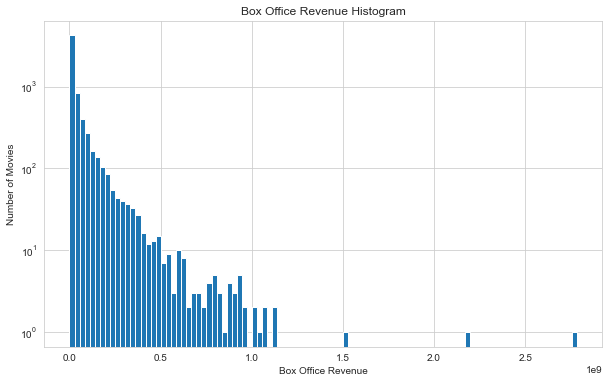

In [96]:
#plot box office revenue with a log scale
plt.figure(figsize=(10, 6))
plt.hist(movie_metadata_df['movie_box_office_revenue'], bins=100, log=True)
plt.xlabel('Box Office Revenue')
plt.ylabel('Number of Movies')
plt.title('Box Office Revenue Histogram')
plt.show()

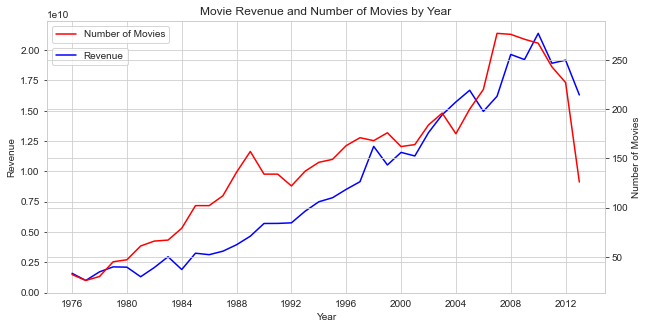

In [97]:
#aggregate movie revenue by year
movie_revenue_by_year = movie_metadata_df.groupby(pd.Grouper(key='movie_release_date', freq='Y'))['movie_box_office_revenue'].sum()
#aggregate number of movies by year ignoring movies with no revenue
movie_with_revenue = movie_metadata_df[movie_metadata_df['movie_box_office_revenue'] > 0]
movie_by_year = movie_with_revenue.groupby(pd.Grouper(key='movie_release_date', freq='Y'))['movie_box_office_revenue'].count()
#plot movie revenue by year
plt.figure(figsize=(10,5))
plt.plot(movie_revenue_by_year.loc['1975':'2012'], color='blue', label='Revenue')
plt.xlabel('Year')
plt.ylabel('Revenue')
plt.legend(loc='upper left', bbox_to_anchor=(0, 0.92))
plt.twinx()
plt.plot(movie_by_year.loc['1975':'2012'], color='red', label='Number of Movies')
plt.ylabel('Number of Movies')
plt.title('Movie Revenue and Number of Movies by Year')
plt.legend(loc='upper left')
plt.show()

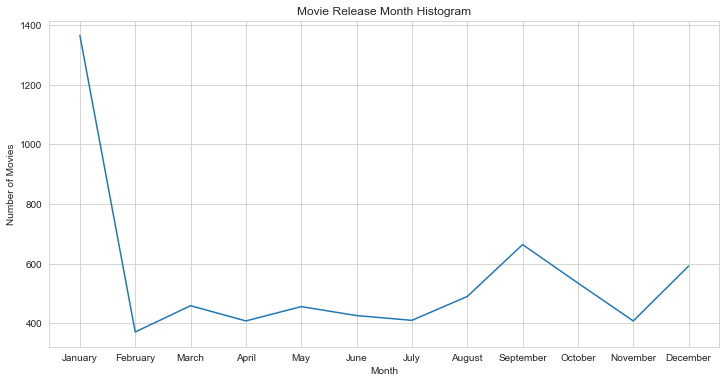

In [98]:
#movies per month ignoring movies with no revenue
movie_per_month = movie_with_revenue.groupby(movie_with_revenue['movie_release_date'].dt.strftime('%m')).count()['freebase_movie_id']
movie_per_month.index = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 
                                'November', 'December']
#plot a histogram of the months with the most movies released
plt.figure(figsize=(12, 6))
plt.plot(movie_per_month)
plt.xlabel('Month')
plt.ylabel('Number of Movies')
plt.title('Movie Release Month Histogram')
plt.show()

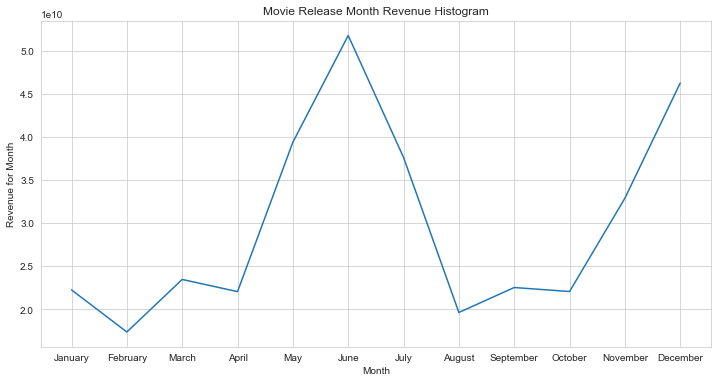

In [99]:
#aggregate movie revenue by month in 12 bins
movie_revenue_by_month = movie_metadata_df.groupby(movie_metadata_df['movie_release_date'].dt.strftime('%m'))['movie_box_office_revenue'].sum()
#change index to month names
movie_revenue_by_month.index = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 
                                'November', 'December']
#plot histogram of movie revenue by month
plt.figure(figsize=(12, 6))
plt.plot(movie_revenue_by_month)
plt.xlabel('Month')
plt.ylabel('Revenue for Month')
plt.title('Movie Release Month Revenue Histogram')
plt.show()

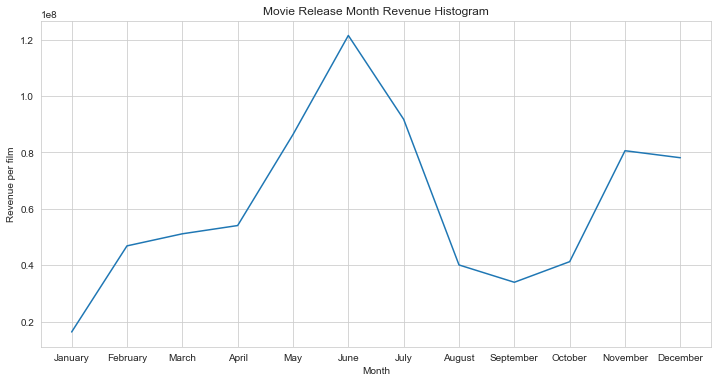

In [100]:
#plot month that are the most profitable
plt.figure(figsize=(12, 6))
plt.plot(movie_revenue_by_month/movie_per_month)
plt.xlabel('Month')
plt.ylabel('Revenue per film')
plt.title('Movie Release Month Revenue Histogram')
plt.show()

In [101]:
#5 longest movies
movie_metadata_df.sort_values(by=['movie_runtime'], ascending=False).head(5)

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,startYear
57255,2551150,/m/07mjjc,Rebound,2005-07-01,17492014.0,1003.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01z02hx"": ""Sports"", ""/m/0hqxf"": ""Family F...",2005
45085,147213,/m/012tj4,Shoah,1985-01-01,NaN,544.0,"{""/m/064_8sq"": ""French Language"", ""/m/03hkp"": ...","{""/m/0f8l9c"": ""France""}","{""/m/03g3w"": ""History"", ""/m/082gq"": ""War film""...",1985
19597,1236676,/m/04l0c9,Empire,1964-01-01,NaN,485.0,"{""/m/06ppq"": ""Silent film""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film"", ""/m/0219x_"": ""Indi...",1964
29772,1236122,/m/04kzqz,Gettysburg,1993-01-01,10769960.0,366.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",1993
38295,2384482,/m/0785tk,Bound by Honor,1993-02-05,35000.0,330.0,"{""/m/0jzc"": ""Arabic Language"", ""/m/02h40lc"": ""...","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F...",1993


In [102]:
#5 longest movies excluding movies longer than 240 minutes (4 hours)
movie_metadata_df[movie_metadata_df['movie_runtime'] < 240].sort_values(by=['movie_runtime'], ascending=False).head(5)

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,startYear
20440,417004,/m/025w1d,The Falls,1980-01-01,NaN,239.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/06n90"": ""Science Fiction"", ""/m/0219x_"": ""...",1980
71128,24583717,/m/0807zzf,Love Exposure,2008-11-29,NaN,237.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/02l7c8"": ""Romance Film"", ""/m/02kdv5l"": ""A...",2008
46328,5883015,/m/0fbp9v,The Lost City,1935-03-06,NaN,236.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/02kdv5l...",1935
76622,770242,/m/03b1xy,Flash Gordon Conquers the Universe,1940-03-09,NaN,234.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/03k9fj"": ""...",1940
37834,2804704,/m/083skw,Gone with the Wind,1939-12-15,400000000.0,234.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/060__y"": ""Film adaptation"", ""/m/04xvh5"": ...",1939


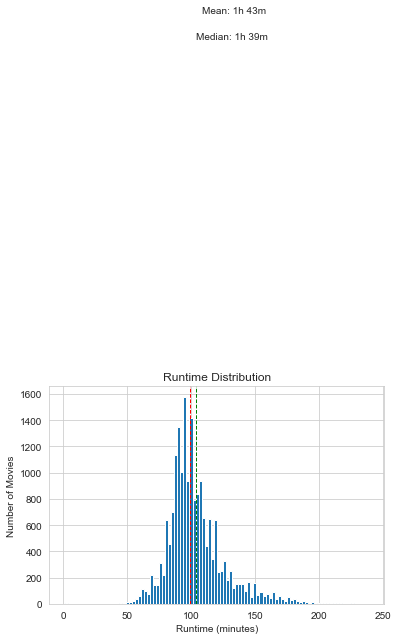

In [103]:
#plot runtime distribution with median and mean
plt.hist(movie_metadata_df[movie_metadata_df['movie_runtime'] < 240]['movie_runtime'], bins=100)
plt.axvline(movie_metadata_df['movie_runtime'].median(), color='red', linestyle='dashed', linewidth=1)
plt.text(movie_metadata_df['movie_runtime'].median() + 5, 4300, 'Median: ' + str(int(movie_metadata_df['movie_runtime'].median()/60)) + 'h ' + str(int(movie_metadata_df['movie_runtime'].median()%60)) + 'm')
plt.axvline(movie_metadata_df['movie_runtime'].mean(), color='green', linestyle='dashed', linewidth=1)
plt.text(movie_metadata_df['movie_runtime'].mean() + 5, 4500, 'Mean: ' + str(int(movie_metadata_df['movie_runtime'].mean()/60)) + 'h ' + str(int(movie_metadata_df['movie_runtime'].mean()%60)) + 'm')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Number of Movies')
plt.title('Runtime Distribution')
plt.show()

In [104]:
#5 shortest movies
movie_metadata_df.sort_values(by=['movie_runtime'], ascending=True).head(5)

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,startYear
54396,2322506,/m/073qxn,Fantastic Planet,1973-12-01,NaN,1.25,"{""/m/064_8sq"": ""French Language""}","{""/m/0f8l9c"": ""France"", ""/m/01mjq"": ""Czech Rep...","{""/m/02hmvc"": ""Short Film"", ""/m/06n90"": ""Scien...",1973
11762,33994214,/m/0hr6p_4,The King of Pigs,2011-10-08,NaN,1.50,{},"{""/m/06qd3"": ""South Korea""}","{""/m/02hmvc"": ""Short Film"", ""/m/0hcr"": ""Animat...",2011
56639,35025043,/m/0j63_8s,I Love You,2007-01-01,NaN,3.00,{},{},"{""/m/02hmvc"": ""Short Film""}",2007
45815,22816098,/m/0641r9w,Double Identity,2009-01-01,NaN,4.00,{},"{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/02wtdps"": ""Crime...",2009
78438,5467528,/m/0dn5gt,Our Relations,1936-10-30,NaN,7.00,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/0hj3mz5"": ""Com...",1936


In [105]:
#extract the actor ethnicity into a Series from the character metadata removing duplicates
actor_ethnicity_series = character_metadata_df["actor_ethnicity"].drop_duplicates().dropna().reset_index(drop=True)
actor_ethnicity_series.head(10)

0    /m/044038p
1       /m/0x67
2     /m/064b9n
3    /m/0dryh9k
4     /m/048sp5
5     /m/04mvp8
6     /m/0bzkm2
7    /m/02p1pl6
8    /m/0bjbszh
9     /m/0ffkb4
Name: actor_ethnicity, dtype: object

In [106]:
def get_wikidata_id(freebase_id):
  sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
  query = f"""
  SELECT ?article ?label
  WHERE 
  {{
    ?article schema:about ?item;
        schema:isPartOf <https://en.wikipedia.org/> .
    ?item wdt:P646 "{freebase_id}";
          rdfs:label ?label.
    FILTER(LANG(?label) = "en") # Optional: Filter by English labels
  }}
  """
  sparql.setQuery(query)
  sparql.setReturnFormat(JSON)
  
  try:
      results = sparql.query().convert()
      if 'results' in results and 'bindings' in results['results'] and len(results['results']['bindings']) > 0:
          return results['results']['bindings'][0]['label']['value']
  except Exception as e:
      print(f"Error: {e}")
      time.sleep(20)
      return get_wikidata_id(freebase_id)
  
  return None

In [107]:
#create a dataframe from the results of the sparql query from every element in actor_ethnicity_series
transformed_values = [get_wikidata_id(value) for value in actor_ethnicity_series]

In [108]:
data = {'ethnicity_id': actor_ethnicity_series, 'ethnicity_name': transformed_values}
df = pd.DataFrame(data)
df.head(10)

,ethnicity_id,ethnicity_name
0,/m/044038p,None
1,/m/0x67,African Americans
2,/m/064b9n,Omaha people
3,/m/0dryh9k,Indian person
4,/m/048sp5,Ezhava
5,/m/04mvp8,Malayali
6,/m/0bzkm2,Taiwanese
7,/m/02p1pl6,None
8,/m/0bjbszh,None
9,/m/0ffkb4,Lithuanian American


In [109]:
#characters that have been played by multiple actors
character_metadata_df[character_metadata_df['character_name'].duplicated(keep=False)].sort_values(by=['character_name'])

,wiki_movie_id,freebase_movie_id,movie_release_date,character_name,actor_date_of_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id
172072,747689,/m/037_84,1979-03-14,'3-5-0-0' Soloist,1950-06-05,M,NaN,NaN,Ronnie Dyson,28.0,/m/0gy_y5r,/m/0h5rdn3,/m/01p27qd
172057,747689,/m/037_84,1979-03-14,'3-5-0-0' Soloist,1945-10-29,F,NaN,/m/0x67,Melba Moore,33.0,/m/0cg6hqj,/m/0h5rdnt,/m/08rgr4
38685,673694,/m/031tc2,1988-08-10,'Jose' Chavez y Chavez,1962-02-17,M,1.85,/m/03295l,Lou Diamond Phillips,26.0,/m/02vcg9t,/m/0h2k5dk,/m/031zkw
29510,675213,/m/031zk3,1990-08-01,'Jose' Chavez y Chavez,1962-02-17,M,1.85,/m/03295l,Lou Diamond Phillips,28.0,/m/02vc4lz,/m/0h2k5dk,/m/031zkw
177246,28370864,/m/0crfcdl,2011-08-12,'Juicy' Judy Gonzalez,1977-03-26,F,1.73,NaN,Bianca Kajlich,34.0,/m/0gvd8fd,/m/0cgm75g,/m/0dlbpj
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450567,22330502,/m/05sync6,1931-01-31,NaN,1889-07-15,F,NaN,NaN,Marjorie Rambeau,NaN,/m/05tg4vt,NaN,/m/079q2l
450584,24997872,/m/09g6klx,2010-05-07,NaN,1972-09-09,M,NaN,/m/01rv7x,Riyaz Khan,37.0,/m/0h888_7,NaN,/m/04645zm
450588,24997872,/m/09g6klx,2010-05-07,NaN,1944-08-01,M,NaN,/m/01rv7x,Delhi Ganesh,65.0,/m/0h6krrl,NaN,/m/04cw5sb
450589,24997872,/m/09g6klx,2010-05-07,NaN,1948-05-22,M,NaN,/m/04mvp8,Nedumudi Venu,61.0,/m/0h7yl4y,NaN,/m/02hkw6


# 4) LARGE REVENUE COORELATION WITH THE IMDB RATINGS

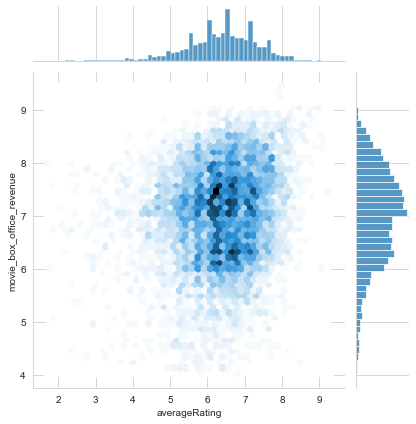

In [110]:
sns.jointplot(x=movies_ratings['averageRating'], y=np.log10(movies_ratings['movie_box_office_revenue']), kind="hex")

In [111]:
# correlation between the average rating and the box office revenue
movies_ratings['averageRating'].corr(movies_ratings['movie_box_office_revenue'])


0.1692386454835258

# 5) Linking events to movies 

In [112]:

print("poportion of data without revenue data: ",movies_ratings['movie_box_office_revenue'].isna().sum()/movies_ratings.shape[0])
print("unique char tropes: ",len(tvtropes_clusters_df['character_type'].unique()))

poportion of data without revenue data:  0.7404737012869966
unique char tropes:  72


In [113]:
# create a new dataframe with character_type, actor_name and count columns
df = tvtropes_clusters_df[['character_type', 'actor_name']]
df['count'] = df.groupby(['character_type', 'actor_name'])['actor_name'].transform('count')
df = df.drop_duplicates()
df.sample(70)
df.sort_values(by='count', ascending=False)
df_roles = tvtropes_clusters_df.groupby('actor_name')['character_type'].agg(list).reset_index(name='roles')
df_roles.sample(10)



,actor_name,roles
102,Heather Langenkamp,[final_girl]
92,Frank Whaley,[crazy_jealous_guy]
93,Gene Wilder,[fastest_gun_in_the_west]
120,Jamie Lee Curtis,[final_girl]
0,Adam Sandler,"[ditz, ditz, warrior_poet]"
289,Takashi Matsuyama,[crazy_jealous_guy]
35,Busy Philipps,[valley_girl]
210,Natalie Portman,[broken_bird]
297,Tom Berenger,"[drill_sargeant_nasty, psycho_for_hire]"
228,Peta Wilson,[heartbroken_badass]


In [114]:
movies_ratings.sample(10)

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,startYear,tconst,averageRating,numVotes,titleType
28472,31676856,/m/0g4nyk4,Sing Your Song,2011-01-21,45765.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0jtdp"": ""Documentary""}",2011,tt1787797,7.5,494,movie
45906,29629987,/m/0fpgx22,The Perfect Gift,2009-11-01,NaN,NaN,{},{},"{""/m/07s9rl0"": ""Drama""}",2009,tt1349640,6.9,456,movie
28977,320527,/m/01vg8l,Pink Flamingos,1972-03-17,7000000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/03npn"": ""Hor...",1972,tt0069089,6.0,27137,movie
44494,19664197,/m/04mwsmp,Beloved Enemy,1936-01-01,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama"", ""/m/01g6gs"": ""Black-an...",1936,tt0027345,6.4,371,movie
5253,33910030,/m/0hnd94g,Solo,2011-11-25,NaN,NaN,{},{},"{""/m/07s9rl0"": ""Drama""}",2011,tt2123294,6.6,393,movie
28990,19152261,/m/04ld1fw,The Pool,2007-01-18,NaN,98.0,"{""/m/03k50"": ""Hindi Language"", ""/m/02h40lc"": ""...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci...",2007,tt0911024,7.2,895,movie
31594,14337608,/m/03d0zvn,The Constant Factor,1980-01-01,NaN,92.0,"{""/m/05qqm"": ""Polish Language""}","{""/m/05qhw"": ""Poland""}","{""/m/07s9rl0"": ""Drama""}",1980,tt0080561,7.1,1081,movie
23278,6043783,/m/0fm5tn,Forty Shades of Blue,2005-01-01,NaN,107.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/068d7h"": ""Romantic drama"", ""/m/02l7c8"": ""...",2005,tt0395543,6.1,1545,movie
43573,28880973,/m/0dd97rg,Fort Massacre,1958-05-01,NaN,81.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/0hfjk"":...",1958,tt0051629,6.2,1033,movie
28551,1446009,/m/0526k9,Mon Oncle,1958-01-01,NaN,116.0,"{""/m/064_8sq"": ""French Language""}","{""/m/0f8l9c"": ""France"", ""/m/03rjj"": ""Italy""}","{""/m/01z4y"": ""Comedy"", ""/m/03q4nz"": ""World cin...",1958,tt0050706,7.7,23784,movie


In [145]:
def json_to_values(json_text):
    try:
        json_data = json.loads(json_text)
        values_list = list(json_data.values())
        return values_list
    except json.JSONDecodeError:
        return None
def jayson_to_keys(df,column_name):
    df_cop = df.copy()
    df_cop[column_name] = df_cop[column_name].apply(json_to_values)
    return df_cop
    
# Apply the function to the DataFrame column



In [137]:
movies_ratings.sample(5)


,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,startYear,tconst,averageRating,numVotes,titleType
42855,27215811,/m/0by1cfx,American Nightmare,1983-01-01,NaN,88.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0d060g"": ""Canada""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th...",1983,tt0085156,5.2,551,movie
38038,171068,/m/016z7s,The Madness of King George,1994-12-28,NaN,109.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/017fp"": ""Biography"", ""/m/04xvh5"": ""Costum...",1994,tt0110428,7.2,17850,movie
13863,13911693,/m/03cn0k6,The Secret Garden,1949-04-30,NaN,92.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama"", ""/m/01g6gs"": ""Black-an...",1949,tt0041855,7.5,3207,movie
19,9633533,/m/02pml15,Vandanam,1989-01-01,NaN,168.0,"{""/m/0999q"": ""Malayalam Language""}","{""/m/03rk0"": ""India""}","{""/m/02kdv5l"": ""Action""}",1989,tt0255668,7.9,1260,movie
13137,465418,/m/02ct58,Mandragora,1997-01-01,NaN,135.0,"{""/m/01wgr"": ""Czech Language""}","{""/m/01mjq"": ""Czech Republic""}","{""/m/0hn10"": ""LGBT"", ""/m/07s9rl0"": ""Drama"", ""/...",1997,tt0119608,6.6,1245,movie


In [251]:
def plot_data(start,movies_ratings,column_name): 
    end = start + 10
    df = jayson_to_keys(movies_ratings, 'movie_genres')
    #filter df to keep the rows with startYear < 10 and > 0
    df = df[(df['startYear'].astype(int)<end) & (df['startYear'].astype(int)>start)]
    df = df.explode('movie_genres')
    df = df[["averageRating","movie_genres"]]
    df['count'] = df.groupby('movie_genres')['movie_genres'].transform('count')
    df = df.groupby(['movie_genres']).mean()
    #add a 'count' column to the dataframe
    df = df.sort_values(by=['count'], ascending=False)
    #plot a hisstogram of the first 10 genres with the most movies 
    
    plt.figure(figsize=(12, 6))
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.bar(df.index[:10], df['count'][:10])
    #print the mean rating of the first 10 genres on the histogram 
    for i, genre in enumerate(df.index[:10]):
        mean_rating = df.loc[genre, 'averageRating']
        plt.text(i, df['count'][i] + 1, f'avg rate: {mean_rating:.2f}', ha='center', va='bottom')

    plt.xlabel('Genre')
    plt.ylabel('Number of Movies')
    plt.title('Genre Histogram')
    plt.show()

In [240]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [252]:
from ipywidgets import IntSlider
interact(plot_data, start=IntSlider(min=1900, max=2010, step=10), movies_ratings=fixed(movies_ratings), column_name=fixed('movie_genres'))


interactive(children=(IntSlider(value=1900, description='start', max=2010, min=1900, step=10), Output()), _dom…

<function __main__.plot_data(start, movies_ratings, column_name)>

In [258]:
from sklearn.linear_model import LinearRegression


In [272]:
def lin_reg_results(X,Y):
    reg = LinearRegression().fit(X, Y)
    print("score: ",reg.score(X, y))
    print("coef: ",reg.coef_)
    print("intercept: ", reg.intercept_,'\n')
    print()


In [274]:
y = movies_ratings['averageRating']
# data without any changes
X = movies_ratings[['numVotes']]
print("no scaling of numVotes :")
lin_reg_results(X,y)
print()
# data with log scaling
X = np.log(movies_ratings[['numVotes']])
print("log scaling of numVotes :")
lin_reg_results(X,y)
# data with sqrt scaling
X = np.sqrt(movies_ratings[['numVotes']])
print("sqrt scaling of numVotes :")
lin_reg_results(X,y)

no scaling of numVotes :
score:  0.045280165732388244
coef:  [2.35342944e-06]
intercept:  6.184441868394912 



log scaling of numVotes :
score:  0.08375039897893755
coef:  [0.16598438]
intercept:  4.931488199197611 


sqrt scaling of numVotes :
score:  0.07281350031382994
coef:  [0.0022854]
intercept:  6.039184538683744 




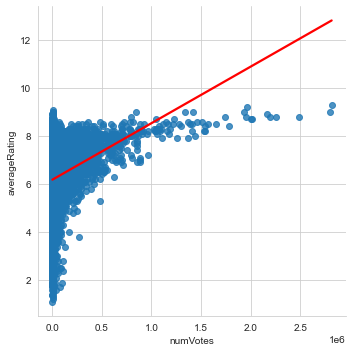

In [264]:
sns.lmplot(x='numVotes', y='averageRating', data=movies_ratings, ci=None, line_kws={'color': 'red'})

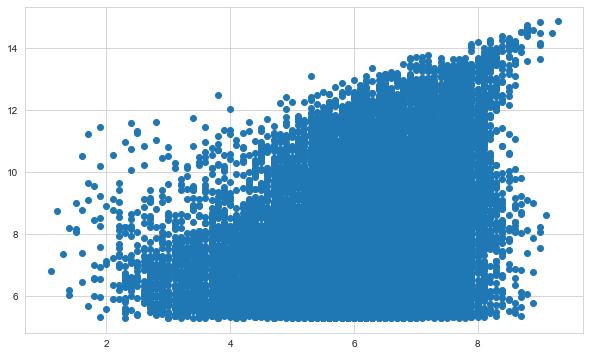

In [257]:
df = movies_ratings.copy()
#normalize the number of votes mean and std
#df['numVotes'] = (df['numVotes'] - df['numVotes'].mean()) / df['numVotes'].std()
#df['numVotes'] = (df['numVotes'] - df['numVotes'].min()) / (df['numVotes'].max() - df['numVotes'].min())

#scatter plot the average rating and the numberr of votes
plt.figure(figsize=(10, 6))
plt.scatter(df['averageRating'],np.log(df['numVotes']))